Preparação do Ambiente

In [5]:
%pip install pandas

     ---------------------------------------- 11.6/11.6 MB 2.7 MB/s eta 0:00:00
  Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
     ---------------------------------------- 15.8/15.8 MB 4.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install matplotlib

     ---------------------------------------- 8.0/8.0 MB 8.1 MB/s eta 0:00:00
     ---------------------------------------- 56.1/56.1 kB ? eta 0:00:00
     -------------------------------------- 187.5/187.5 kB 5.7 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 3.3 MB/s eta 0:00:00
     -------------------------------------- 103.2/103.2 kB 6.2 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 3.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install statsmodels

     ---------------------------------------- 9.8/9.8 MB 9.5 MB/s eta 0:00:00
     ---------------------------------------- 46.2/46.2 MB 6.6 MB/s eta 0:00:00
     ------------------------------------- 233.9/233.9 kB 14.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install scikit-learn

     --------------------------------------- 11.0/11.0 MB 10.4 MB/s eta 0:00:00
     -------------------------------------- 301.8/301.8 kB 6.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [14]:
%pip install xgboost


     ---------------------------------------- 99.8/99.8 MB 3.0 MB/s eta 0:00:00


importei as bibliotecas necessárias para a análise

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

carreguei os dados de produção de leite a partir de um arquivo CSV e renomei a coluna para leite_Producao. Em seguida, logo depois plotei os dados para uma visualização inicial da série temporal.

In [68]:
# Carregar os dados
data = pd.read_csv('C:\\Users\\eliz1\\Desktop\\cesarSschool2024\\SeriesTemporais\\atividade_2_ElizaneaCampelo\\milk.txt', header=None)
data.columns = ['leite_Producao']

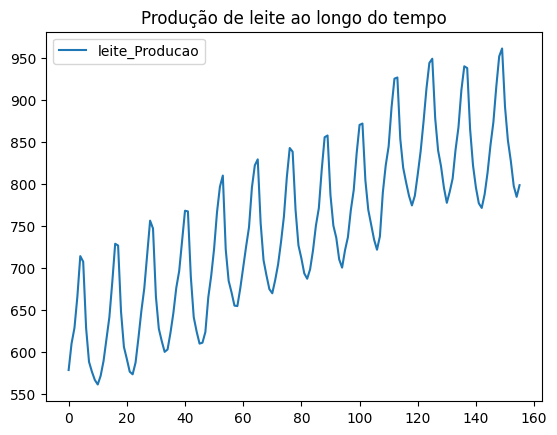

In [69]:
# Visualizar os dados    
# sugere que a produção de leite está crescendo de maneira geral, 
# com variações sazonais significativas ao longo do tempo
data.plot()
plt.title('Produção de leite ao longo do tempo')
plt.show()

dividi os dados em dois conjuntos: treino (80%) e teste (20%). 
O conjunto de treino é usado para ajustar os modelos, 
enquanto o conjunto de teste é usado para avaliar a performance.

In [70]:
# Dividir os dados em treino e teste (80% treino, 20% teste)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

Logo mais ajustei o modelo ARIMA nos dados de treino com parâmetros (5,1,0) (AR, I, MA). 
Depois, usei o modelo ajustado para prever os valores no conjunto de teste. 
assim alinhei o índice das previsões com o índice dos dados de teste.

In [71]:
# Ajustar o modelo ARIMA
arima_model = ARIMA(train, order=(5,1,0))
arima_fit = arima_model.fit()

In [53]:
# Previsões ARIMA
arima_pred = arima_fit.forecast(steps=len(test))
arima_pred = pd.Series(arima_pred, index=test.index)  # Alinhar o índice

Criei features (variáveis explicativas) para os modelos de Random Forest e XGBoost. 
utilizei 12 lags (valores anteriores) como features. 
A função create_features gera essas features e remove valores NaN resultantes do deslocamento (shift).

In [54]:
# Criar features para Random Forest e XGBoost
def create_features(data, lags=12):
    features = pd.DataFrame(data)
    for lag in range(1, lags+1):
        features[f'lag_{lag}'] = data.shift(lag)
    return features.dropna()

In [55]:
# Aplicar a função para criar features
train_features = create_features(train['milk_production'])
test_features = create_features(test['milk_production'])

In [56]:
# Dividir em X (features) e y (target)
X_train, y_train = train_features.drop('milk_production', axis=1), train_features['milk_production']
X_test, y_test = test_features.drop('milk_production', axis=1), test_features['milk_production']

modelo Random Forest usando os dados de treino
Fazendo previsões para o conjunto de teste. As previsões são alinhadas com o índice dos dados de teste

In [57]:
# Ajustar o modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [58]:
# Previsões Random Forest
rf_pred = rf_model.predict(X_test)
rf_pred = pd.Series(rf_pred, index=y_test.index)  # Alinhar o índice

Ajustei modelo XGBoost nos dados de treino.  
fiz previsões para o conjunto de teste. As previsões também são alinhadas com o índice dos dados de teste.

In [59]:
# Ajustar o modelo XGBoost
xgb_model = XGBRegressor(n_estimators=100)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [60]:
# Previsões XGBoost
xgb_pred = xgb_model.predict(X_test)
xgb_pred = pd.Series(xgb_pred, index=y_test.index)  # Alinhar o índice

defini uma função para calcular o MSE e o MAPE e avaliei cada modelo utilizando essas métricas. 
enfim o resumo dos resultados em um DataFrame e os exibimos.

In [61]:
# Função para calcular MSE e MAPE
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mape

In [62]:
# Avaliação ARIMA
arima_mse, arima_mape = evaluate_model(test['milk_production'], arima_pred)

In [63]:
# Avaliação Random Forest
rf_mse, rf_mape = evaluate_model(y_test, rf_pred)

In [64]:
# Avaliação XGBoost
xgb_mse, xgb_mape = evaluate_model(y_test, xgb_pred)

In [65]:
# Resumo dos resultados
results = pd.DataFrame({
    'Model': ['ARIMA', 'Random Forest', 'XGBoost'],
    'MSE': [arima_mse, rf_mse, xgb_mse],
    'MAPE': [arima_mape, rf_mape, xgb_mape]
})

print(results)

           Model          MSE      MAPE
0          ARIMA  2645.263443  0.053664
1  Random Forest  1194.207924  0.035936
2        XGBoost  1030.442996  0.031516
